In [1]:
import pandas as pd
import os
import numpy as np # Needed for load_product_time_series

# --- Configuration ---
base_path = "./" # Confirmed working path

# --- Define Historical File Paths for BOTH 2023 and 2024 ---

# Define structure for multiple years
historical_years_config = {
    2023: {
        "base_folder": "2023_data_bottle",
        "rounds": {
            1: {'folder': 'island-data-bottle-round-1', 'days': [-2, -1, 0]},
            2: {'folder': 'island-data-bottle-round-2', 'days': [-1, 0, 1]},
            3: {'folder': 'island-data-bottle-round-3', 'days': [0, 1, 2]},
            4: {'folder': 'island-data-bottle-round-4', 'days': [1, 2, 3]},
        }
    },
    2024: {
        "base_folder": "2024_data_bottle",
        "rounds": {
            1: {'folder': 'round-1-island-data-bottle', 'days': [-2, -1, 0]}, # Adjusted folder name based on screenshot
            2: {'folder': 'round-2-island-data-bottle', 'days': [-1, 0, 1]},
            3: {'folder': 'round-3-island-data-bottle', 'days': [0, 1, 2]},
            4: {'folder': 'round-4-island-data-bottle', 'days': [1, 2, 3]}, # Ignoring consolidated file for now
            # Round 5 from screenshot seems to only have trades, no prices, so excluded.
        }
    }
}

# Dictionary to hold the list of valid file paths for each year and round
historical_files_by_year_round = {}

print("--- Locating Historical Price Files (2023 & 2024) ---")
for year, year_config in historical_years_config.items():
    year_base_path = os.path.join(base_path, year_config["base_folder"])
    historical_files_by_year_round[year] = {}
    print(f"\nChecking Year {year} in folder: {year_config['base_folder']}")

    for round_num, round_info in year_config["rounds"].items():
        round_folder_path = os.path.join(year_base_path, round_info['folder'])
        round_files = []
        # Construct file name pattern (e.g., prices_round_1_day_...)
        file_pattern = f"prices_round_{round_num}_day_"
        print(f"  Checking Round {round_num} in folder: {round_info['folder']}")

        for day in round_info['days']:
            file_path = os.path.join(round_folder_path, f"{file_pattern}{day}.csv")
            if os.path.exists(file_path):
                 print(f"    Found: {os.path.basename(file_path)}") # Print only filename for brevity
                 round_files.append(file_path)
            else:
                print(f"    [Warning] Expected file not found, skipping: {os.path.basename(file_path)}")

        if round_files: # Only add the round if price files were found
            historical_files_by_year_round[year][round_num] = round_files
        else:
            print(f"  [Warning] No price files found for Year {year} Round {round_num}")


# --- Reusable Function to Load Product Time Series (remains the same) ---
# [Ensure the full 'load_product_time_series' function definition is included here]
def load_product_time_series(file_paths, product_name, relevant_columns=None, verbose=False):
    """Loads, concatenates, and sorts time series data for a specific product."""
    if not file_paths:
        if verbose: print(f"No file paths provided for loading '{product_name}'.")
        return pd.DataFrame() # Return empty DataFrame

    if relevant_columns is None:
        relevant_columns = ['day', 'timestamp', 'product',
                            'bid_price_1', 'bid_volume_1',
                            'ask_price_1', 'ask_volume_1',
                            'mid_price']

    all_product_data = []
    # if verbose: print(f"Loading data for '{product_name}' from {len(file_paths)} files...")

    for file_path in file_paths:
        try:
            day_df = pd.read_csv(file_path, sep=';')
            product_df = day_df[day_df['product'] == product_name].copy()
            if not product_df.empty:
                cols_to_select = [col for col in relevant_columns if col in product_df.columns]
                if 'mid_price' in relevant_columns and 'mid_price' not in product_df.columns:
                     # if verbose: print(f"  [Warning] 'mid_price' column missing in {file_path} for {product_name}. Skipping this part.")
                     continue
                product_df = product_df[cols_to_select]
                all_product_data.append(product_df)
        except FileNotFoundError:
             if verbose: print(f"  [WARNING] File not found during load: {file_path}")
        except Exception as e:
            if verbose: print(f"  [ERROR] Failed to read/process {file_path} for {product_name}: {e}")

    if not all_product_data:
        return pd.DataFrame(columns=relevant_columns + ['combined_timestamp'])

    full_series_df = pd.concat(all_product_data, ignore_index=True)

    if 'day' not in full_series_df.columns or 'timestamp' not in full_series_df.columns:
        # print(f"[Error] 'day' or 'timestamp' column missing for {product_name} after concat.")
        return pd.DataFrame()
    if 'mid_price' in relevant_columns and 'mid_price' not in full_series_df.columns:
         # print(f"[Error] 'mid_price' column missing for {product_name} after concat.")
         return pd.DataFrame()

    unique_days_sorted = sorted(full_series_df['day'].unique())
    day_map = {day: i for i, day in enumerate(unique_days_sorted)}
    full_series_df['day_sequence'] = full_series_df['day'].map(day_map)
    full_series_df['combined_timestamp'] = (full_series_df['day_sequence'] * 1000000) + full_series_df['timestamp']
    full_series_df = full_series_df.sort_values(by='combined_timestamp').reset_index(drop=True)
    final_columns_present = [col for col in relevant_columns if col in full_series_df.columns] + ['combined_timestamp']
    final_columns_unique = list(dict.fromkeys(final_columns_present))
    full_series_df = full_series_df[final_columns_unique]
    return full_series_df
# --- End of load_product_time_series function ---


# --- Load ALL Historical Commodities (Now including 2023 & 2024) ---
print("\n--- Loading ALL Historical Commodities (2023 & 2024) ---")

# This dictionary will store all the loaded historical data
# Structure: {year: {round_number: {product_name: DataFrame_with_time_series}}}
all_historical_data = {}

# Iterate through each year defined in the config
for year, rounds_in_year in historical_files_by_year_round.items():
    print(f"\n-- Processing Historical Year {year} --")
    all_historical_data[year] = {} # Initialize the dictionary for this year

    # Iterate through each round found for this year
    for round_num, file_paths in rounds_in_year.items():
        print(f"  -- Processing Round {round_num} --")
        if not file_paths: # Should not happen based on earlier logic
            print("    No files found for this round, skipping.")
            continue

        # Initialize the dictionary for this round
        all_historical_data[year][round_num] = {}
        round_products = set()

        # Step 1: Find unique product names within this round's files
        print(f"    Identifying unique products...")
        for file_path in file_paths:
            try:
                day_df = pd.read_csv(file_path, sep=';', usecols=['product'])
                round_products.update(day_df['product'].unique())
            except ValueError:
                 print(f"      [Warning] 'product' column not found or issue reading products from {os.path.basename(file_path)}")
            except Exception as e:
                print(f"      [Warning] Could not read products from {os.path.basename(file_path)}: {e}")

        unique_round_products = sorted(list(round_products))
        print(f"    Found {len(unique_round_products)} unique products.")

        # Step 2: Load the time series for each unique product in this round
        print(f"    Loading time series data...")
        count_loaded = 0
        for product in unique_round_products:
            # Use verbose=False for less console output during loading
            historical_ts_df = load_product_time_series(file_paths, product, verbose=False)
            if not historical_ts_df.empty:
                all_historical_data[year][round_num][product] = historical_ts_df
                count_loaded += 1

        print(f"    Successfully loaded time series data for {count_loaded} out of {len(unique_round_products)} products.")


print(f"\n--- Historical Data Loading Complete (2023 & 2024) ---")
total_rounds_loaded = sum(len(rounds) for rounds in all_historical_data.values())
total_historical_series = sum(len(products) for year_data in all_historical_data.values() for products in year_data.values())
print(f"Total historical time series loaded across {len(all_historical_data)} years and {total_rounds_loaded} rounds: {total_historical_series}")
print(f"Data is structured as: all_historical_data[year][round_number][product_name]")

# --- Example Usage (Optional) ---
example_year = 2024
example_round = 1
example_product = 'PEARLS' # Check if PEARLS exists in 2024 Round 1

if example_year in all_historical_data and \
   example_round in all_historical_data[example_year] and \
   example_product in all_historical_data[example_year][example_round]:
    print(f"\nExample: Accessing '{example_product}' data from Year {example_year} Round {example_round}:")
    example_df = all_historical_data[example_year][example_round][example_product]
    print(f"Shape: {example_df.shape}")
    print(example_df.head())
else:
    print(f"\nExample data for Year {example_year}, Round {example_round}, Product '{example_product}' not found in loaded data.")

# --- Ready for Comparison ---
# The comparison code (Correlation, Plotting, DTW) will need to be updated
# next to iterate through this new nested structure:
# for year, rounds_in_year in all_historical_data.items():
#    for round_num, products_in_round in rounds_in_year.items():
#        for product_name, hist_df in products_in_round.items():
#            # ... perform comparison with target_ts_df ...

print("\nHistorical data for 2023 and 2024 is now loaded. Ready to adapt the comparison steps.")

--- Locating Historical Price Files (2023 & 2024) ---

Checking Year 2023 in folder: 2023_data_bottle
  Checking Round 1 in folder: island-data-bottle-round-1
    Found: prices_round_1_day_-2.csv
    Found: prices_round_1_day_-1.csv
    Found: prices_round_1_day_0.csv
  Checking Round 2 in folder: island-data-bottle-round-2
    Found: prices_round_2_day_-1.csv
    Found: prices_round_2_day_0.csv
    Found: prices_round_2_day_1.csv
  Checking Round 3 in folder: island-data-bottle-round-3
    Found: prices_round_3_day_0.csv
    Found: prices_round_3_day_1.csv
    Found: prices_round_3_day_2.csv
  Checking Round 4 in folder: island-data-bottle-round-4
    Found: prices_round_4_day_1.csv
    Found: prices_round_4_day_2.csv
    Found: prices_round_4_day_3.csv

Checking Year 2024 in folder: 2024_data_bottle
  Checking Round 1 in folder: round-1-island-data-bottle
    Found: prices_round_1_day_-2.csv
    Found: prices_round_1_day_-1.csv
    Found: prices_round_1_day_0.csv
  Checking Round 2 i


--- Loading Target Commodity: SQUID_INK (Current Round) ---
Loaded target 'SQUID_INK', shape: (30000, 9)

--- Checking for Pre-loaded Historical Data ('all_historical_data') from 2023 & 2024 ---
Found pre-loaded 'all_historical_data' with 2 years and 32 total series.

--- Running Linear Correlation Analysis vs 2023 & 2024 Data (mid_price) ---

--- Top Overall Linear Correlation Matches (vs 2023 & 2024) ---
   historical_year  historical_round historical_product  correlation  \
0             2023                 3            BANANAS       0.8518   
1             2023                 1            BANANAS       0.8004   
2             2023                 4           BAGUETTE      -0.7823   
3             2023                 4        DIVING_GEAR      -0.7727   
4             2023                 3           COCONUTS       0.7552   

   abs_correlation   scale     offset  
0           0.8518  1.1120 -3465.8568  
1           0.8004  0.9948 -2982.0027  
2           0.7823 -0.2410  4866.524

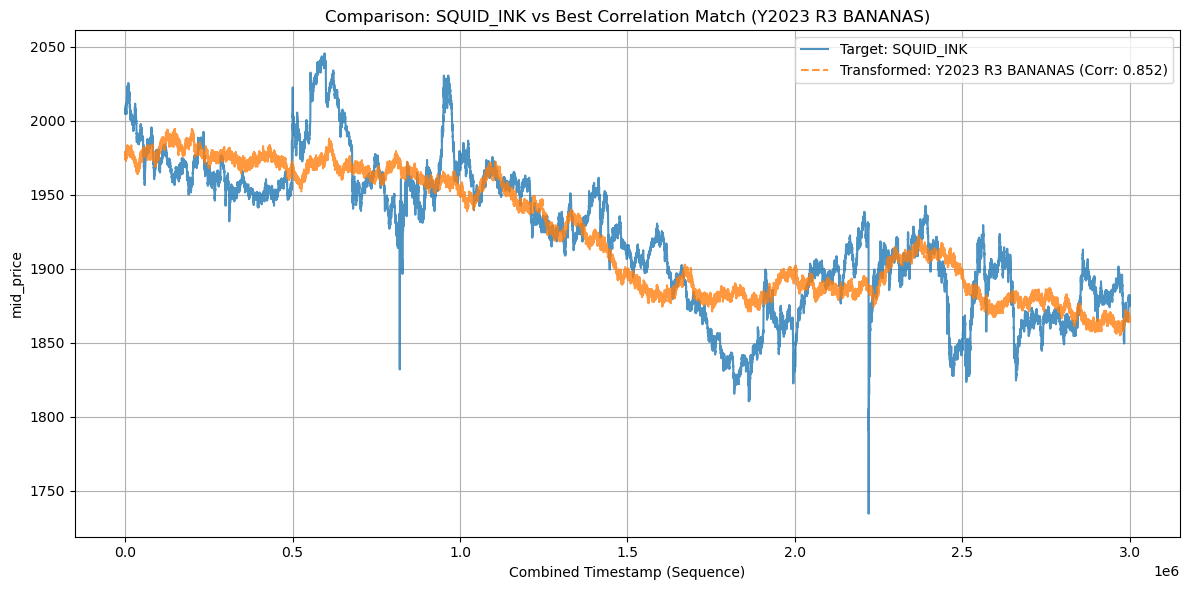


--- Running Dynamic Time Warping (DTW) Analysis vs 2023 & 2024 (mid_price) ---
*** Applying downsampling with factor: 15 ***
Downsampled target series length for DTW: 2000
  DTW vs Year 2023...
  DTW vs Year 2024...

--- Top 10 DTW Matches (vs 2023 & 2024) ---
   historical_year  historical_round historical_product  \
0             2023                 3       PINA_COLADAS   
1             2023                 3            BERRIES   
2             2023                 3           COCONUTS   
3             2023                 3            BANANAS   
4             2023                 4           COCONUTS   
5             2023                 1            BANANAS   
6             2023                 4            UKULELE   
7             2024                 3              ROSES   
8             2023                 4       PINA_COLADAS   
9             2023                 4            BANANAS   

   dtw_normalized_distance  compared_length_downsampled  
0                   0.1006    

In [ ]:
import pandas as pd
import os
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
from dtw import dtw

# --- Configuration & Setup ---
base_path = "./"
target_commodity_current = 'S' # Commodity to analyze from the current round
target_column = 'mid_price'           # Data column to compare
num_plots_to_show = 1                 # Plot only the best correlation match
num_dtw_results_to_show = 10          # Show top 10 DTW matches
# Set desired DTW downsampling factor (e.g., 25 or 100, based on previous runs)
dtw_downsample_factor = 15            # Using 25 as requested before

# --- Helper Function Definition ---
# [Ensure the full 'load_product_time_series' function definition is included here]
def load_product_time_series(file_paths, product_name, relevant_columns=None, verbose=False):
    """Loads, concatenates, and sorts time series data for a specific product."""
    if not file_paths:
        if verbose: print(f"No file paths provided for loading '{product_name}'.")
        return pd.DataFrame() # Return empty DataFrame

    if relevant_columns is None:
        relevant_columns = ['day', 'timestamp', 'product',
                            'bid_price_1', 'bid_volume_1',
                            'ask_price_1', 'ask_volume_1',
                            'mid_price']

    all_product_data = []
    if verbose: print(f"Loading data for '{product_name}' from {len(file_paths)} files...")

    for file_path in file_paths:
        try:
            day_df = pd.read_csv(file_path, sep=';')
            product_df = day_df[day_df['product'] == product_name].copy()
            if not product_df.empty:
                cols_to_select = [col for col in relevant_columns if col in product_df.columns]
                if 'mid_price' in relevant_columns and 'mid_price' not in product_df.columns:
                     if verbose: print(f"  [Warning] 'mid_price' column missing in {file_path} for {product_name}. Skipping this part.")
                     continue
                product_df = product_df[cols_to_select]
                all_product_data.append(product_df)
        except FileNotFoundError:
             if verbose: print(f"  [WARNING] File not found during load: {file_path}")
        except Exception as e:
            if verbose: print(f"  [ERROR] Failed to read/process {file_path} for {product_name}: {e}")

    if not all_product_data:
        return pd.DataFrame(columns=relevant_columns + ['combined_timestamp'])

    full_series_df = pd.concat(all_product_data, ignore_index=True)

    if 'day' not in full_series_df.columns or 'timestamp' not in full_series_df.columns:
        # print(f"[Error] 'day' or 'timestamp' column missing for {product_name} after concat.")
        return pd.DataFrame()
    if 'mid_price' in relevant_columns and 'mid_price' not in full_series_df.columns:
         # print(f"[Error] 'mid_price' column missing for {product_name} after concat.")
         return pd.DataFrame()

    unique_days_sorted = sorted(full_series_df['day'].unique())
    day_map = {day: i for i, day in enumerate(unique_days_sorted)}
    full_series_df['day_sequence'] = full_series_df['day'].map(day_map)
    full_series_df['combined_timestamp'] = (full_series_df['day_sequence'] * 1000000) + full_series_df['timestamp']
    full_series_df = full_series_df.sort_values(by='combined_timestamp').reset_index(drop=True)
    final_columns_present = [col for col in relevant_columns if col in full_series_df.columns] + ['combined_timestamp']
    final_columns_unique = list(dict.fromkeys(final_columns_present))
    full_series_df = full_series_df[final_columns_unique]
    return full_series_df
# --- End of load_product_time_series function ---


# --- Load Target Commodity ---
print(f"\n--- Loading Target Commodity: {target_commodity_current} (Current Round) ---")
# Assuming current round is 2025 R2
current_comp_base = os.path.join(base_path, "2025_data_bottle", "round-2-island-data-bottle")
current_files_paths = [
    os.path.join(current_comp_base, f"prices_round_2_day_{day}.csv") for day in [-1, 0, 1]
    if os.path.exists(os.path.join(current_comp_base, f"prices_round_2_day_{day}.csv"))
]
target_ts_df = load_product_time_series(current_files_paths, target_commodity_current, verbose=False) # Less verbose loading
if target_ts_df.empty:
    print(f"Error: Could not load data for target commodity: {target_commodity_current}. Exiting.")
    exit()
else:
     print(f"Loaded target '{target_commodity_current}', shape: {target_ts_df.shape}")


# --- Check for Pre-loaded Historical Data ---
print("\n--- Checking for Pre-loaded Historical Data ('all_historical_data') from 2023 & 2024 ---")
if 'all_historical_data' not in locals() or not isinstance(all_historical_data, dict) or not all_historical_data:
     print("\n*** Error: 'all_historical_data' (containing 2023 & 2024 data) not found or empty! ***")
     print("Ensure the combined historical loading script ran successfully first.")
     exit()
else:
    total_series = sum(len(products) for year_data in all_historical_data.values() for products in year_data.values())
    print(f"Found pre-loaded 'all_historical_data' with {len(all_historical_data)} years and {total_series} total series.")


# --- Prepare Target Series (Raw) ---
if target_column not in target_ts_df.columns:
    print(f"Error: Target column '{target_column}' not found in target DataFrame.")
    exit()
target_series_raw = target_ts_df[target_column].dropna()
if target_series_raw.empty:
    print(f"Error: Target series '{target_column}' is empty after dropna.")
    exit()
target_values_raw = target_series_raw.values
target_timestamps = target_ts_df.loc[target_series_raw.index, 'combined_timestamp']


# ============================================================================
# Part 1: Linear Correlation Analysis (Iterating through Years/Rounds)
# ============================================================================
print(f"\n--- Running Linear Correlation Analysis vs 2023 & 2024 Data ({target_column}) ---")
correlation_results = [] # Store results for ALL comparisons

# Iterate through years (2023, 2024)
for year, rounds_in_year in all_historical_data.items():
    # Iterate through rounds (1, 2, 3, 4) within the year
    for round_num, products_in_round in rounds_in_year.items():
        # Iterate through products within the round
        for product_name, hist_df in products_in_round.items():
            if target_column not in hist_df.columns: continue
            hist_series = hist_df[target_column].dropna()
            if hist_series.empty: continue

            hist_values = hist_series.values
            min_len = min(len(target_values_raw), len(hist_values))
            if min_len < 2: continue

            aligned_target = target_values_raw[:min_len]
            aligned_hist = hist_values[:min_len]

            if np.std(aligned_target) < 1e-9 or np.std(aligned_hist) < 1e-9: continue

            try:
                slope, intercept, r_value, p_value, std_err = linregress(aligned_hist, aligned_target)
                correlation = r_value
            except Exception: continue

            # Store results including year and round
            correlation_results.append({
                'historical_year': year, # Add year
                'historical_round': round_num,
                'historical_product': product_name,
                'correlation': correlation, 'scale': slope, 'offset': intercept,
                'p_value': p_value, 'compared_length': min_len
            })

# --- Display Top Correlation Results (Sorted) ---
results_df = pd.DataFrame()
if not correlation_results:
    print("\nLinear Correlation: No comparisons could be made.")
else:
    results_df = pd.DataFrame(correlation_results)
    results_df['abs_correlation'] = results_df['correlation'].abs()
    # Sort by absolute correlation
    results_df = results_df.sort_values(by='abs_correlation', ascending=False).reset_index(drop=True)
    print("\n--- Top Overall Linear Correlation Matches (vs 2023 & 2024) ---")
    # Show top 5, including year and round
    print(results_df[['historical_year', 'historical_round', 'historical_product', 'correlation', 'abs_correlation', 'scale', 'offset']].round(4).head())


# ============================================================================
# Part 2: Plotting Top Correlation Match (Adapting data retrieval)
# ============================================================================
if not results_df.empty and num_plots_to_show > 0:
    print(f"\n--- Plotting Top {num_plots_to_show} Overall Correlation Match ---")
    # Plotting loop will run for the top row(s) of the sorted results_df
    for i, row in results_df.head(num_plots_to_show).iterrows():
        # Retrieve year, round, product from the results row
        hist_year = row['historical_year']
        hist_round = row['historical_round']
        hist_product = row['historical_product']
        hist_scale = row['scale']
        hist_offset = row['offset']
        hist_len = row['compared_length'] # Length used for correlation calc

        # Get the full historical data using year and round
        hist_df_full = all_historical_data[hist_year][hist_round][hist_product]
        hist_series_full = hist_df_full[target_column].dropna()
        hist_values_full = hist_series_full.values
        hist_timestamps = hist_df_full.loc[hist_series_full.index, 'combined_timestamp']

        plot_len = min(hist_len, len(target_values_raw), len(hist_values_full))
        transformed_hist_aligned = hist_values_full[:plot_len] * hist_scale + hist_offset

        plt.figure(figsize=(12, 6))
        plt.plot(target_timestamps[:plot_len], target_values_raw[:plot_len], label=f'Target: {target_commodity_current}', alpha=0.8)
        plt.plot(hist_timestamps[:plot_len], transformed_hist_aligned, label=f'Transformed: Y{hist_year} R{hist_round} {hist_product} (Corr: {row["correlation"]:.3f})', linestyle='--', alpha=0.8)
        plt.title(f"Comparison: {target_commodity_current} vs Best Correlation Match (Y{hist_year} R{hist_round} {hist_product})")
        plt.xlabel("Combined Timestamp (Sequence)")
        plt.ylabel(target_column)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
    plt.show()
elif results_df.empty:
     print("\nPlotting Skipped: No correlation results were generated.")


# ============================================================================
# Part 3: Dynamic Time Warping (DTW) Analysis (Iterating through Years/Rounds)
# ============================================================================
print(f"\n--- Running Dynamic Time Warping (DTW) Analysis vs 2023 & 2024 ({target_column}) ---")
print(f"*** Applying downsampling with factor: {dtw_downsample_factor} ***")

# --- Standardization Function ---
def standardize(series):
    series_float = series.astype(float)
    mean = np.mean(series_float)
    std = np.std(series_float)
    if std < 1e-9: return series_float - mean
    return (series_float - mean) / std

# --- Downsample and Standardize Target Series ---
if len(target_values_raw) < dtw_downsample_factor:
    print(f"Warning: Target series length ({len(target_values_raw)}) is less than downsample factor ({dtw_downsample_factor}). Cannot perform DTW.")
    dtw_results = []
else:
    target_values_downsampled = target_values_raw[::dtw_downsample_factor]
    target_values_std_downsampled = standardize(target_values_downsampled)
    print(f"Downsampled target series length for DTW: {len(target_values_downsampled)}")

    dtw_results = []
    # --- Iterate through historical data (Years -> Rounds -> Products) ---
    for year, rounds_in_year in all_historical_data.items():
        print(f"  DTW vs Year {year}...")
        for round_num, products_in_round in rounds_in_year.items():
             # print(f"    DTW vs Round {round_num}...") # Can be too verbose
             for product_name, hist_df in products_in_round.items():
                # Process Historical Series
                if target_column not in hist_df.columns: continue
                hist_series = hist_df[target_column].dropna()
                if hist_series.empty: continue
                hist_values_raw = hist_series.values
                if len(hist_values_raw) < dtw_downsample_factor: continue
                hist_values_downsampled = hist_values_raw[::dtw_downsample_factor]

                # Align Lengths (Downsampled)
                min_len_downsampled = min(len(target_values_downsampled), len(hist_values_downsampled))
                if min_len_downsampled < 2: continue

                aligned_target_std_downsampled = target_values_std_downsampled[:min_len_downsampled]
                aligned_hist_downsampled = hist_values_downsampled[:min_len_downsampled]
                aligned_hist_std_downsampled = standardize(aligned_hist_downsampled)

                if np.all(np.abs(aligned_target_std_downsampled) < 1e-9) or np.all(np.abs(aligned_hist_std_downsampled) < 1e-9): continue

                # Calculate DTW
                try:
                    alignment = dtw(aligned_target_std_downsampled, aligned_hist_std_downsampled,
                                    keep_internals=False, open_end=True)
                    distance = alignment.distance
                    normalized_distance = alignment.normalizedDistance
                except Exception as e:
                    print(f"      [Warning] Skipping Y{year} R{round_num} {product_name}: DTW Error: {e}")
                    continue

                # Store results including year and round
                dtw_results.append({
                    'historical_year': year, # Add year
                    'historical_round': round_num,
                    'historical_product': product_name,
                    'dtw_distance': distance, 'dtw_normalized_distance': normalized_distance,
                    'compared_length_downsampled': min_len_downsampled,
                    'downsample_factor': dtw_downsample_factor
                })

# --- Display DTW Results ---
if not dtw_results:
    print("\nDTW Analysis: No results generated.")
else:
    dtw_results_df = pd.DataFrame(dtw_results)
    # Sort by NORMALIZED DTW distance
    dtw_results_df = dtw_results_df.sort_values(by='dtw_normalized_distance', ascending=True).reset_index(drop=True)
    print(f"\n--- Top {num_dtw_results_to_show} DTW Matches (vs 2023 & 2024) ---")
    # Show results including year and round
    print(dtw_results_df[['historical_year', 'historical_round', 'historical_product', 'dtw_normalized_distance', 'compared_length_downsampled']].round(4).head(num_dtw_results_to_show))


print("\n--- Analysis Complete ---")


--- Loading Target Commodity: KELP (Current Round) ---
Loaded target 'KELP', shape: (30000, 9)

--- Checking for Pre-loaded Historical Data ('all_historical_data') from 2023 & 2024 ---
Found pre-loaded 'all_historical_data' with 2 years and 32 total series.
Calculated target log returns. Length: 29999

--- Running Linear Regression on Log Returns (vs 2023 & 2024) ---
Identifying matches with R-squared >= 0.90

--- Top Overall Log Return Regression Matches (Sorted by R²) ---
   historical_year  historical_round historical_product  r_squared    beta  \
0             2023                 2            BANANAS     0.0402  0.2254   
1             2023                 2             PEARLS     0.0094  0.1753   
2             2023                 3            BANANAS     0.0003 -0.0182   
3             2023                 4            BERRIES     0.0001  0.0165   
4             2023                 4             PEARLS     0.0001 -0.0172   

   alpha  
0    0.0  
1    0.0  
2    0.0  
3    0.

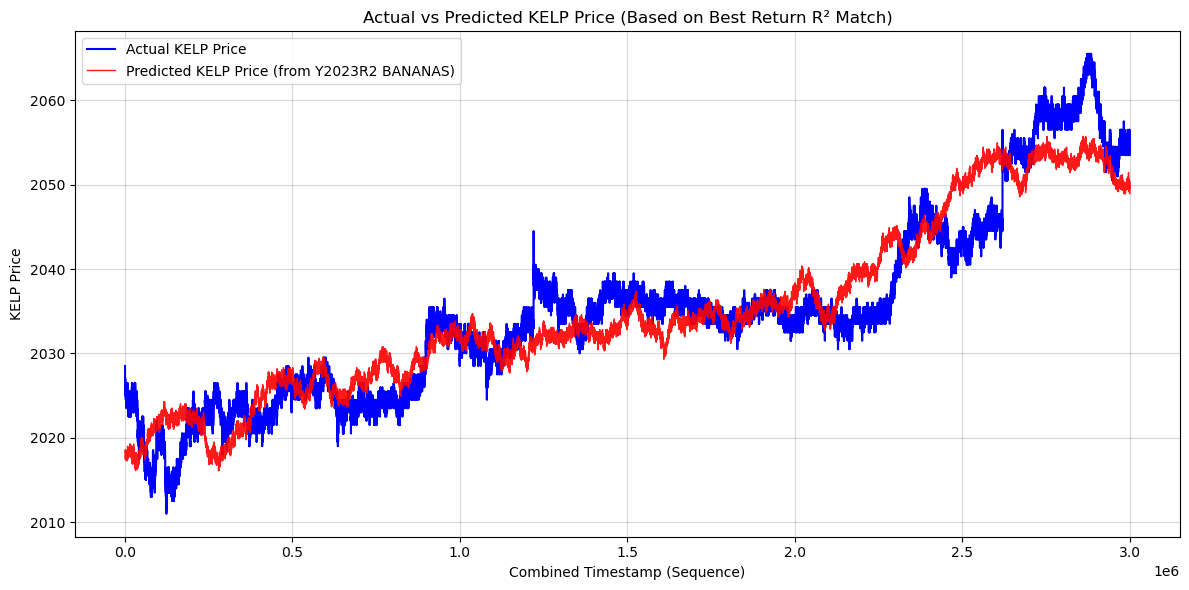


--- Running Dynamic Time Warping (DTW) Analysis (mid_price Prices) ---
*** Applying downsampling with factor: 25 ***
Downsampled target price series length for DTW: 1200
  DTW vs Year 2023 Prices...
  DTW vs Year 2024 Prices...

--- Top 10 DTW Matches (mid_price Prices - Lower Norm Dist is More Similar Shape) ---
   historical_year  historical_round historical_product  \
0             2023                 4  DOLPHIN_SIGHTINGS   
1             2024                 3       STRAWBERRIES   
2             2023                 4        DIVING_GEAR   
3             2023                 4           BAGUETTE   
4             2023                 3  DOLPHIN_SIGHTINGS   
5             2024                 1          STARFRUIT   
6             2023                 2       PINA_COLADAS   
7             2024                 4     COCONUT_COUPON   
8             2023                 4      PICNIC_BASKET   
9             2023                 2           COCONUTS   

   dtw_normalized_distance  compar

In [ ]:
# ============================================================================
# == Prerequisites:                                                        ==
# == 1. Install libraries: pip install pandas numpy matplotlib dtw-python scipy ==
# == 2. Run the combined 2023 & 2024 historical data loading script first   ==
# ==    to populate the 'all_historical_data' dictionary.                  ==
# ============================================================================

import pandas as pd
import os
import numpy as np
from scipy.stats import linregress # For linear regression
import matplotlib.pyplot as plt    # For plotting
from dtw import dtw                # For Dynamic Time Warping

# --- Configuration & Setup ---
base_path = "./" # Assumes script is run in dir containing data bottles
target_commodity_current = '' # Target commodity from current round (Change if needed)
target_column = 'mid_price'           # Data column for analysis
r2_threshold = 0.90                   # Threshold for printing high R-squared matches (can be lower like 0.5 to see more)
num_plots_r2_price_to_show = 1      # Plot only the best R-squared match (price prediction)
num_dtw_results_to_show = 10          # Show top 10 DTW matches (on prices)
# Set desired DTW downsampling factor (e.g., 25 or 100)
dtw_downsample_factor = 25            # Factor for downsampling before DTW on prices

# --- Helper Function Definition ---
# [This function is needed to load the target commodity]
def load_product_time_series(file_paths, product_name, relevant_columns=None, verbose=False):
    """Loads, concatenates, and sorts time series data for a specific product."""
    if not file_paths:
        if verbose: print(f"No file paths provided for loading '{product_name}'.")
        return pd.DataFrame()

    if relevant_columns is None:
        relevant_columns = ['day', 'timestamp', 'product',
                            'bid_price_1', 'bid_volume_1',
                            'ask_price_1', 'ask_volume_1',
                            'mid_price']

    all_product_data = []
    if verbose: print(f"Loading data for '{product_name}' from {len(file_paths)} files...")

    for file_path in file_paths:
        try:
            day_df = pd.read_csv(file_path, sep=';')
            product_df = day_df[day_df['product'] == product_name].copy()
            if not product_df.empty:
                cols_to_select = [col for col in relevant_columns if col in product_df.columns]
                if 'mid_price' in relevant_columns and 'mid_price' not in product_df.columns:
                     if verbose: print(f"  [Warning] 'mid_price' missing in {os.path.basename(file_path)} for {product_name}.")
                     continue
                product_df = product_df[cols_to_select]
                all_product_data.append(product_df)
        except FileNotFoundError:
             if verbose: print(f"  [Warning] File not found: {file_path}")
        except Exception as e:
            if verbose: print(f"  [ERROR] Reading {os.path.basename(file_path)} for {product_name}: {e}")

    if not all_product_data:
        return pd.DataFrame(columns=relevant_columns + ['combined_timestamp'])

    full_series_df = pd.concat(all_product_data, ignore_index=True)

    if 'day' not in full_series_df.columns or 'timestamp' not in full_series_df.columns:
        return pd.DataFrame()
    if 'mid_price' in relevant_columns and 'mid_price' not in full_series_df.columns:
         return pd.DataFrame()

    unique_days_sorted = sorted(full_series_df['day'].unique())
    day_map = {day: i for i, day in enumerate(unique_days_sorted)}
    full_series_df['day_sequence'] = full_series_df['day'].map(day_map)
    full_series_df['combined_timestamp'] = (full_series_df['day_sequence'] * 1000000) + full_series_df['timestamp']
    full_series_df = full_series_df.sort_values(by='combined_timestamp').reset_index(drop=True)
    final_columns_present = [col for col in relevant_columns if col in full_series_df.columns] + ['combined_timestamp']
    final_columns_unique = list(dict.fromkeys(final_columns_present))
    full_series_df = full_series_df[final_columns_unique]
    return full_series_df
# --- End of load_product_time_series function ---


# --- Load Target Commodity ---
print(f"\n--- Loading Target Commodity: {target_commodity_current} (Current Round) ---")
# Assuming current round is 2025 R2
current_comp_base = os.path.join(base_path, "2025_data_bottle", "round-2-island-data-bottle")
current_files_paths = [
    os.path.join(current_comp_base, f"prices_round_2_day_{day}.csv") for day in [-1, 0, 1]
    if os.path.exists(os.path.join(current_comp_base, f"prices_round_2_day_{day}.csv"))
]
target_ts_df = load_product_time_series(current_files_paths, target_commodity_current, verbose=False)
if target_ts_df.empty:
    print(f"Error: Could not load data for target commodity: {target_commodity_current}. Exiting.")
    exit()
else:
     print(f"Loaded target '{target_commodity_current}', shape: {target_ts_df.shape}")


# --- Check for Pre-loaded Historical Data ---
print("\n--- Checking for Pre-loaded Historical Data ('all_historical_data') from 2023 & 2024 ---")
if 'all_historical_data' not in locals() or not isinstance(all_historical_data, dict) or not all_historical_data:
     print("\n*** Error: 'all_historical_data' dictionary not found or empty! ***")
     print("Please ensure the combined 2023 & 2024 historical data loading script")
     print("has been run successfully in the current session BEFORE running this script.")
     exit()
else:
    total_series = sum(len(products) for year_data in all_historical_data.values() for products in year_data.values())
    print(f"Found pre-loaded 'all_historical_data' with {len(all_historical_data)} years and {total_series} total series.")


# --- Prepare Target Series (Raw Prices and Log Returns) ---
if target_column not in target_ts_df.columns: exit(f"Target column '{target_column}' missing.")
target_series_raw = target_ts_df[target_column].dropna()
if target_series_raw.empty: exit("Target series empty after dropna.")
target_values_raw = target_series_raw.values
target_timestamps = target_ts_df.loc[target_series_raw.index, 'combined_timestamp'] # Timestamps for plotting

# Calculate Target Log Returns
epsilon = 1e-10
if len(target_values_raw) < 2: exit("Target series too short to calculate returns.")
target_log_prices = np.log(target_values_raw + epsilon)
target_log_returns = np.diff(target_log_prices) # Length is N-1
print(f"Calculated target log returns. Length: {len(target_log_returns)}")


# ============================================================================
# Part 1: Linear Regression on LOG RETURNS (R-squared focus)
# ============================================================================
print(f"\n--- Running Linear Regression on Log Returns (vs 2023 & 2024) ---")
print(f"Identifying matches with R-squared >= {r2_threshold:.2f}")
return_regression_results = [] # Store ALL results here as well

for year, rounds_in_year in all_historical_data.items():
    for round_num, products_in_round in rounds_in_year.items():
        for product_name, hist_df in products_in_round.items():
            if target_column not in hist_df.columns: continue
            # Calculate Historical Log Returns
            hist_series_raw = hist_df[target_column].dropna()
            if len(hist_series_raw) < 2: continue
            hist_values_raw = hist_series_raw.values
            hist_log_prices = np.log(hist_values_raw + epsilon)
            hist_log_returns = np.diff(hist_log_prices)

            # Align RETURN Series
            min_len_returns = min(len(target_log_returns), len(hist_log_returns))
            if min_len_returns < 2: continue
            aligned_target_returns = target_log_returns[:min_len_returns]
            aligned_hist_returns = hist_log_returns[:min_len_returns]

            # Check for Constant Returns
            if np.std(aligned_target_returns) < 1e-12 or np.std(aligned_hist_returns) < 1e-12: continue

            # Perform Linear Regression on Returns
            try:
                slope, intercept, r_value, p_value, std_err = linregress(aligned_hist_returns, aligned_target_returns)
                r_squared = r_value ** 2
            except Exception: continue

            # Store ALL results
            result_entry = {
                'historical_year': year, 'historical_round': round_num,
                'historical_product': product_name, 'r_squared': r_squared,
                'beta': slope, 'alpha': intercept, 'p_value': p_value,
                'compared_length_returns': min_len_returns
            }
            return_regression_results.append(result_entry)

            # Print if R-squared Exceeds Threshold
            if r_squared >= r2_threshold:
                print(f"  >>> High R-squared Found: Y{year} R{round_num} {product_name} | R²: {r_squared:.4f} | Beta: {slope:.4f}")


# --- Display Top R-squared Results (Sorted) ---
results_returns_df = pd.DataFrame() # Ensure DataFrame exists
if not return_regression_results:
    print(f"\nLog Return Regression: No valid comparisons could be made.")
else:
    results_returns_df = pd.DataFrame(return_regression_results)
    # Sort by R-squared descending
    results_returns_df = results_returns_df.sort_values(by='r_squared', ascending=False).reset_index(drop=True)
    print(f"\n--- Top Overall Log Return Regression Matches (Sorted by R²) ---")
    # Display top 5 results found, regardless of R² value
    print(results_returns_df[['historical_year', 'historical_round', 'historical_product', 'r_squared', 'beta', 'alpha']].round(4).head())


# ============================================================================
# Part 2: Plotting Actual vs. Predicted PRICE based on Best R² Return Match
# ============================================================================
print("\n--- Generating Price Prediction Plot based on Best Overall R² Return Match ---")

# Check if any return regression results were generated
if results_returns_df.empty:
     print("\nPlotting Skipped: No return regression results were generated.")
else:
    # Get the details of the single best match (highest R²)
    best_r2_match = results_returns_df.iloc[0]
    hist_year = int(best_r2_match['historical_year'])
    hist_round = int(best_r2_match['historical_round'])
    hist_product = best_r2_match['historical_product']
    print(f"Plotting based on Best R² match found: Y{hist_year} R{hist_round} {hist_product} (R²={best_r2_match['r_squared']:.4f})")

    # Perform secondary regression on PRICES for this specific pair
    print(f"Performing secondary regression on PRICES for Y{hist_year} R{hist_round} {hist_product}...")
    # Safely access historical data
    if hist_year in all_historical_data and hist_round in all_historical_data[hist_year] and hist_product in all_historical_data[hist_year][hist_round]:
        hist_df_best = all_historical_data[hist_year][hist_round][hist_product]
        hist_series_raw_best = hist_df_best[target_column].dropna()

        if not hist_series_raw_best.empty:
            hist_values_raw_best = hist_series_raw_best.values
            min_len_prices = min(len(target_values_raw), len(hist_values_raw_best))

            if min_len_prices >= 2:
                aligned_target_prices = target_values_raw[:min_len_prices]
                aligned_hist_prices = hist_values_raw_best[:min_len_prices]

                # Check for constant price series before regression
                if np.std(aligned_target_prices) > 1e-9 and np.std(aligned_hist_prices) > 1e-9:
                    try:
                        # Regress TargetPrice = scale * HistPrice + offset
                        price_scale, price_offset, price_r_value, _, _ = linregress(aligned_hist_prices, aligned_target_prices)
                        print(f"  Price Regression Results: Scale={price_scale:.4f}, Offset={price_offset:.4f}, Correlation={price_r_value:.4f}")

                        # Generate Predicted Prices
                        predicted_prices = price_scale * aligned_hist_prices + price_offset
                        plot_timestamps = target_timestamps[:min_len_prices] # Use corresponding target timestamps

                        # Create the Price Plot
                        plt.figure(figsize=(12, 6))
                        plt.plot(plot_timestamps, aligned_target_prices, label=f'Actual {target_commodity_current} Price', color='blue', linewidth=1.5)
                        plt.plot(plot_timestamps, predicted_prices, label=f'Predicted {target_commodity_current} Price (from Y{hist_year}R{hist_round} {hist_product})', color='red', linewidth=1.0, alpha=0.9)
                        plt.title(f"Actual vs Predicted {target_commodity_current} Price (Based on Best Return R² Match)")
                        plt.xlabel("Combined Timestamp (Sequence)")
                        plt.ylabel(f"{target_commodity_current} Price")
                        plt.legend()
                        plt.grid(True, alpha=0.5)
                        plt.tight_layout()
                        plt.show() # Display the plot

                    except Exception as e:
                        print(f"  Error during price regression or plotting: {e}")
                else:
                    print("  Skipping price plot: One or both price series are constant.")
            else:
                print("  Skipping price plot: Insufficient overlapping price data points.")
        else:
            print(f"  Skipping price plot: Price data for Y{hist_year}R{hist_round} {hist_product} is empty after dropna.")
    else:
         print(f"  Skipping price plot: Could not retrieve historical data for Y{hist_year}R{hist_round} {hist_product}.")


# ============================================================================
# Part 3: Dynamic Time Warping (DTW) Analysis (Using PRICES)
# ============================================================================
print(f"\n--- Running Dynamic Time Warping (DTW) Analysis ({target_column} Prices) ---")
print(f"*** Applying downsampling with factor: {dtw_downsample_factor} ***")

# --- Standardization Function ---
def standardize(series):
    series_float = series.astype(float); mean = np.mean(series_float); std = np.std(series_float)
    if std < 1e-9: return series_float - mean
    return (series_float - mean) / std

# --- Downsample and Standardize Target Series (Prices) ---
if len(target_values_raw) < dtw_downsample_factor:
    print(f"Warning: Target series too short for DTW downsampling factor {dtw_downsample_factor}.")
    dtw_results = []
else:
    target_values_downsampled = target_values_raw[::dtw_downsample_factor]
    target_values_std_downsampled = standardize(target_values_downsampled)
    print(f"Downsampled target price series length for DTW: {len(target_values_downsampled)}")
    dtw_results = []

    # --- Iterate through historical data (Years -> Rounds -> Products) ---
    for year, rounds_in_year in all_historical_data.items():
        print(f"  DTW vs Year {year} Prices...")
        for round_num, products_in_round in rounds_in_year.items():
             for product_name, hist_df in products_in_round.items():
                # Process Historical Prices
                if target_column not in hist_df.columns: continue
                hist_series = hist_df[target_column].dropna()
                if hist_series.empty: continue
                hist_values_raw = hist_series.values
                if len(hist_values_raw) < dtw_downsample_factor: continue
                hist_values_downsampled = hist_values_raw[::dtw_downsample_factor]
                # Align Lengths (Downsampled)
                min_len_downsampled = min(len(target_values_downsampled), len(hist_values_downsampled))
                if min_len_downsampled < 2: continue
                aligned_target_std_downsampled = target_values_std_downsampled[:min_len_downsampled]
                aligned_hist_downsampled = hist_values_downsampled[:min_len_downsampled]
                aligned_hist_std_downsampled = standardize(aligned_hist_downsampled)
                if np.all(np.abs(aligned_target_std_downsampled) < 1e-9) or np.all(np.abs(aligned_hist_std_downsampled) < 1e-9): continue
                # Calculate DTW on Prices
                try:
                    alignment = dtw(aligned_target_std_downsampled, aligned_hist_std_downsampled,
                                    keep_internals=False, open_end=True)
                    distance = alignment.distance; normalized_distance = alignment.normalizedDistance
                except Exception as e:
                    print(f"      [Warning] Skipping Y{year} R{round_num} {product_name} Prices DTW: {e}")
                    continue
                # Store DTW results
                dtw_results.append({
                    'historical_year': year, 'historical_round': round_num, 'historical_product': product_name,
                    'dtw_distance': distance, 'dtw_normalized_distance': normalized_distance,
                    'compared_length_downsampled': min_len_downsampled, 'downsample_factor': dtw_downsample_factor
                })

# --- Display DTW Results ---
if not dtw_results:
    print("\nDTW Analysis: No results generated.")
else:
    dtw_results_df = pd.DataFrame(dtw_results)
    dtw_results_df = dtw_results_df.sort_values(by='dtw_normalized_distance', ascending=True).reset_index(drop=True)
    print(f"\n--- Top {num_dtw_results_to_show} DTW Matches ({target_column} Prices - Lower Norm Dist is More Similar Shape) ---")
    print(dtw_results_df[['historical_year', 'historical_round', 'historical_product', 'dtw_normalized_distance', 'compared_length_downsampled']].round(4).head(num_dtw_results_to_show))


print("\n--- Analysis Complete ---")

In [5]:
import pandas as pd
import os
import numpy as np # Needed by load_product_time_series

# --- Configuration ---
# Specify the path to the file containing the price data (even if misnamed)
price_data_file_path = "./control.csv"
# Specify the product you want to extract from this file
product_to_extract = "RAINFOREST_RESIN"

# --- Helper Function Definition ---
# [Ensure the full 'load_product_time_series' function definition from previous
#  responses is included here. It handles the loading and processing.]
def load_product_time_series(file_paths, product_name, relevant_columns=None, verbose=False):
    """Loads, concatenates, and sorts time series data for a specific product."""
    if not file_paths:
        if verbose: print(f"No file paths provided for loading '{product_name}'.")
        return pd.DataFrame()

    if relevant_columns is None:
        relevant_columns = ['day', 'timestamp', 'product',
                            'bid_price_1', 'bid_volume_1',
                            'ask_price_1', 'ask_volume_1',
                            'mid_price']

    all_product_data = []
    if verbose: print(f"Loading data for '{product_name}' from {len(file_paths)} files...")

    for file_path in file_paths:
        if verbose: print(f"  Reading: {file_path}")
        try:
            # Use sep=';' because the file content uses semicolons
            day_df = pd.read_csv(file_path, sep=';')
            product_df = day_df[day_df['product'] == product_name].copy()
            if not product_df.empty:
                cols_to_select = [col for col in relevant_columns if col in product_df.columns]
                if 'mid_price' in relevant_columns and 'mid_price' not in product_df.columns:
                     if verbose: print(f"  [Warning] 'mid_price' missing in {os.path.basename(file_path)} for {product_name}.")
                     continue
                product_df = product_df[cols_to_select]
                all_product_data.append(product_df)
        except FileNotFoundError:
             if verbose: print(f"  [Warning] File not found: {file_path}")
        except KeyError as e:
             # Specifically catch if 'product' column doesn't exist after reading
             print(f"  [ERROR] Column '{e}' not found in {os.path.basename(file_path)}. Check header and delimiter.")
             return pd.DataFrame() # Stop processing if essential column missing
        except Exception as e:
            if verbose: print(f"  [ERROR] Reading {os.path.basename(file_path)} for {product_name}: {e}")

    if not all_product_data:
         if verbose: print(f"No data found for '{product_name}' in the provided files.")
         final_cols = [col for col in relevant_columns] # Base columns
         if 'day' in relevant_columns and 'timestamp' in relevant_columns: final_cols.append('combined_timestamp')
         return pd.DataFrame(columns=list(dict.fromkeys(final_cols)))

    full_series_df = pd.concat(all_product_data, ignore_index=True)

    if 'day' not in full_series_df.columns or 'timestamp' not in full_series_df.columns:
        print(f"[Error] Critical columns 'day' or 'timestamp' missing for {product_name} after concat from {file_paths}.")
        return pd.DataFrame()
    if 'mid_price' in relevant_columns and 'mid_price' not in full_series_df.columns:
         print(f"[Warning] 'mid_price' column missing for {product_name} after concat, proceeding without it.")
         # Decide if you need to exit or just proceed without mid_price analysis later

    # Calculate combined_timestamp
    unique_days_sorted = sorted(full_series_df['day'].unique())
    day_map = {day: i for i, day in enumerate(unique_days_sorted)}
    full_series_df['day_sequence'] = full_series_df['day'].map(day_map)
    full_series_df['combined_timestamp'] = (full_series_df['day_sequence'] * 1000000) + full_series_df['timestamp']
    full_series_df = full_series_df.sort_values(by='combined_timestamp').reset_index(drop=True)

    # Final column selection
    final_columns_present = [col for col in relevant_columns if col in full_series_df.columns] + ['combined_timestamp']
    final_columns_unique = list(dict.fromkeys(final_columns_present))
    full_series_df = full_series_df[final_columns_unique]
    return full_series_df
# --- End of load_product_time_series function ---


print(f"\n--- Attempting to read price data from: '{price_data_file_path}' ---")
print(f"Extracting data specifically for product: '{product_to_extract}'")

# Check if the file exists before attempting to read
if not os.path.exists(price_data_file_path):
    print(f"[ERROR] File not found at '{price_data_file_path}'")
    exit() # Exit if file doesn't exist

# Call the loading function, passing the file path in a list
# Set verbose=True to see details of the reading process
extracted_data_df = load_product_time_series(
    file_paths=[price_data_file_path],
    product_name=product_to_extract,
    verbose=True
)

# --- Check and display results ---
if extracted_data_df is not None and not extracted_data_df.empty:
    print(f"\n[SUCCESS] Successfully extracted data for '{product_to_extract}' from '{price_data_file_path}'.")
    print(f"Shape: {extracted_data_df.shape}")
    print("\nSample of extracted data:")
    print(extracted_data_df.head())
    # The extracted data is now stored in the 'extracted_data_df' variable
    # You can now use this DataFrame for your algorithm.
else:
    print(f"\n[INFO] No data found for product '{product_to_extract}' within the file '{price_data_file_path}',")
    print("       or an error occurred during loading (check messages above).")


--- Attempting to read price data from: './control.csv' ---
Extracting data specifically for product: 'RAINFOREST_RESIN'
Loading data for 'RAINFOREST_RESIN' from 1 files...
  Reading: ./control.csv

[SUCCESS] Successfully extracted data for 'RAINFOREST_RESIN' from './control.csv'.
Shape: (10000, 9)

Sample of extracted data:
   day  timestamp           product  bid_price_1  bid_volume_1  ask_price_1  \
0    1          0  RAINFOREST_RESIN         9992            31        10008   
1    1        100  RAINFOREST_RESIN         9992            27        10008   
2    1        200  RAINFOREST_RESIN        10001             1        10008   
3    1        300  RAINFOREST_RESIN        10001             1        10008   
4    1        400  RAINFOREST_RESIN         9992            28        10003   

   ask_volume_1  mid_price  combined_timestamp  
0            31    10000.0                   0  
1            27    10000.0                 100  
2            25    10004.5                 200  
3


--- Checking for Pre-loaded Control and Historical Data ---
Using 'RAINFOREST_RESIN' (from control file) as target (Shape: (10000, 9)).
Comparing against 32 historical series from 'all_historical_data'.
Calculated target log returns. Length: 9999

--- Running Linear Regression on Log Returns (RAINFOREST_RESIN vs 2023 & 2024) ---
Identifying matches with R-squared >= 0.90

--- Top Overall Log Return Regression Matches (Sorted by R²) ---
   historical_year  historical_round historical_product  r_squared    beta  \
0             2023                 4             PEARLS     0.0053  0.1070   
1             2023                 4           COCONUTS     0.0005  0.0636   
2             2023                 1            BANANAS     0.0004  0.0191   
3             2024                 3        GIFT_BASKET     0.0002  0.0427   
4             2023                 3             PEARLS     0.0002 -0.0220   

   alpha  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4   -0.0  

--- Generating Price Pr

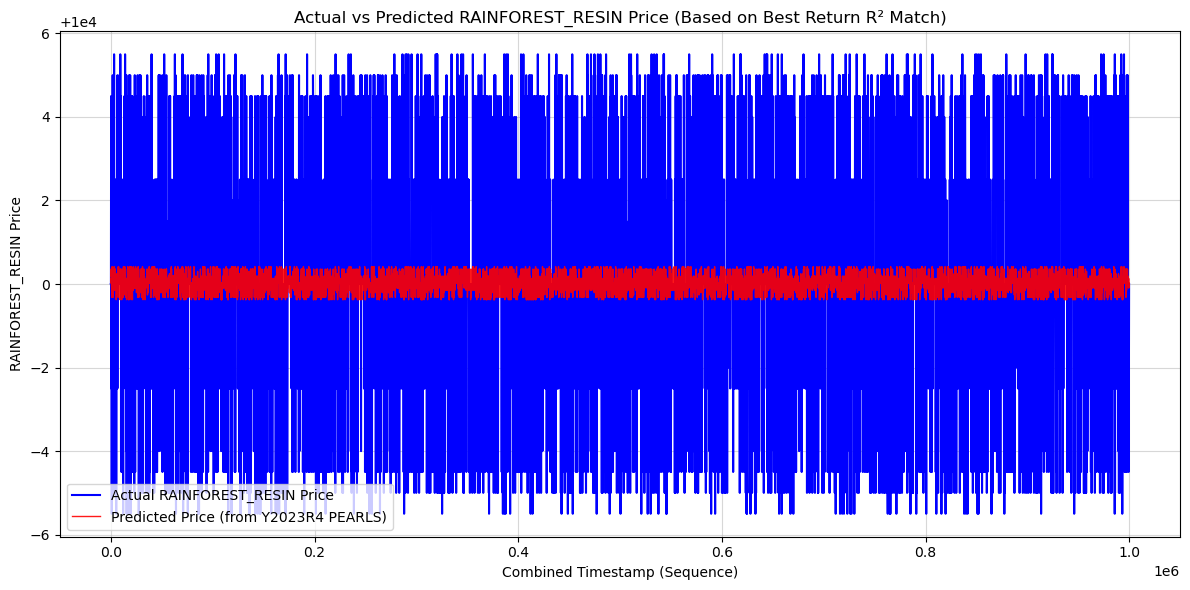


--- Running Dynamic Time Warping (DTW) Analysis (mid_price Prices) ---
*** Applying downsampling with factor: 25 ***
Downsampled target price series length for DTW: 400
  DTW vs Year 2023 Prices...
  DTW vs Year 2024 Prices...

--- Top 10 DTW Matches (mid_price Prices - Lower Norm Dist is More Similar Shape) ---
   historical_year  historical_round historical_product  \
0             2023                 1             PEARLS   
1             2024                 1          AMETHYSTS   
2             2023                 3             PEARLS   
3             2023                 4             PEARLS   
4             2023                 2             PEARLS   
5             2023                 4            BERRIES   
6             2023                 4            UKULELE   
7             2024                 3        GIFT_BASKET   
8             2024                 3       STRAWBERRIES   
9             2023                 3            BANANAS   

   dtw_normalized_distance  compare

In [21]:
# ============================================================================
# == Prerequisites:                                                        ==
# == 1. Libraries installed (pandas, numpy, matplotlib, dtw, scipy).      ==
# == 2. 'all_historical_data' dictionary (2023&2024) loaded in session.   ==
# == 3. 'extracted_data_df' DataFrame (from reading control.csv as prices) ==
# ==    loaded in session.                                                 ==
# == 4. 'product_to_extract' variable (name of product in extracted_data_df) ==
# ==    defined in session.                                                ==
# ============================================================================

import pandas as pd
import os
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
from dtw import dtw

# --- Configuration for Comparison ---
target_column = 'mid_price'           # Data column for analysis
r2_threshold = 0.90                   # Threshold for highlighting high R-squared return matches
num_plots_r2_price_to_show = 1      # Plot only the best R-squared match (price prediction)
num_dtw_results_to_show = 10          # Show top 10 DTW matches (on prices)
dtw_downsample_factor = 25            # Factor for downsampling before DTW on prices
epsilon = 1e-10                     # Small value to avoid log(0)

# --- Check if Required Data Exists ---
print("\n--- Checking for Pre-loaded Control and Historical Data ---")
data_missing = False
if 'product_to_extract' not in locals():
    print("Error: 'product_to_extract' variable not found.")
    data_missing = True
if 'extracted_data_df' not in locals() or not isinstance(extracted_data_df, pd.DataFrame) or extracted_data_df.empty:
    print("Error: Control data ('extracted_data_df') not loaded or empty.")
    print("       Please run the script to read the control file as price data first.")
    data_missing = True
if 'all_historical_data' not in locals() or not isinstance(all_historical_data, dict) or not all_historical_data:
     print("Error: 'all_historical_data' dictionary not found or empty.")
     print("       Please ensure the combined 2023 & 2024 loading script ran successfully.")
     data_missing = True

if data_missing:
    exit("Cannot proceed without required pre-loaded data.")
else:
    target_ts_df = extracted_data_df # Use the loaded data as the target
    target_commodity_current = product_to_extract
    total_series = sum(len(products) for year_data in all_historical_data.values() for products in year_data.values())
    print(f"Using '{target_commodity_current}' (from control file) as target (Shape: {target_ts_df.shape}).")
    print(f"Comparing against {total_series} historical series from 'all_historical_data'.")


# --- Prepare Target Series (Raw Prices and Log Returns) ---
if target_column not in target_ts_df.columns: exit(f"Target column '{target_column}' missing.")
target_series_raw = target_ts_df[target_column].dropna()
if target_series_raw.empty: exit("Target series empty after dropna.")
target_values_raw = target_series_raw.values
target_timestamps = target_ts_df.loc[target_series_raw.index, 'combined_timestamp'] # Timestamps for plotting

# Calculate Target Log Returns
if len(target_values_raw) < 2: exit("Target series too short to calculate returns.")
target_log_prices = np.log(target_values_raw + epsilon)
target_log_returns = np.diff(target_log_prices) # Length is N-1
print(f"Calculated target log returns. Length: {len(target_log_returns)}")


# ============================================================================
# Part 1: Linear Regression on LOG RETURNS (R-squared focus)
# ============================================================================
print(f"\n--- Running Linear Regression on Log Returns ({target_commodity_current} vs 2023 & 2024) ---")
print(f"Identifying matches with R-squared >= {r2_threshold:.2f}")
return_regression_results = [] # Store ALL results

for year, rounds_in_year in all_historical_data.items():
    for round_num, products_in_round in rounds_in_year.items():
        for product_name, hist_df in products_in_round.items():
            if target_column not in hist_df.columns: continue
            # Calculate Historical Log Returns
            hist_series_raw = hist_df[target_column].dropna()
            if len(hist_series_raw) < 2: continue
            hist_values_raw_cmp = hist_series_raw.values
            hist_log_prices = np.log(hist_values_raw_cmp + epsilon)
            hist_log_returns = np.diff(hist_log_prices)

            # Align RETURN Series
            min_len_returns = min(len(target_log_returns), len(hist_log_returns))
            if min_len_returns < 2: continue
            aligned_target_returns = target_log_returns[:min_len_returns]
            aligned_hist_returns = hist_log_returns[:min_len_returns]

            # Check for Constant Returns
            if np.std(aligned_target_returns) < 1e-12 or np.std(aligned_hist_returns) < 1e-12: continue

            # Perform Linear Regression on Returns
            try:
                slope, intercept, r_value, p_value, std_err = linregress(aligned_hist_returns, aligned_target_returns)
                r_squared = r_value ** 2
            except Exception: continue

            # Store ALL results
            result_entry = {
                'historical_year': year, 'historical_round': round_num,
                'historical_product': product_name, 'r_squared': r_squared,
                'beta': slope, 'alpha': intercept, 'p_value': p_value,
                'compared_length_returns': min_len_returns
            }
            return_regression_results.append(result_entry)

            # Print if R-squared Exceeds Threshold
            if r_squared >= r2_threshold:
                print(f"  >>> High R-squared Found: Y{year} R{round_num} {product_name} | R²: {r_squared:.4f} | Beta: {slope:.4f}")

# --- Display Top R-squared Results (Sorted) ---
results_returns_df = pd.DataFrame() # Ensure DataFrame exists
if not return_regression_results:
    print(f"\nLog Return Regression: No valid comparisons could be made.")
else:
    results_returns_df = pd.DataFrame(return_regression_results)
    results_returns_df = results_returns_df.sort_values(by='r_squared', ascending=False).reset_index(drop=True)
    print(f"\n--- Top Overall Log Return Regression Matches (Sorted by R²) ---")
    print(results_returns_df[['historical_year', 'historical_round', 'historical_product', 'r_squared', 'beta', 'alpha']].round(4).head())


# ============================================================================
# Part 2: Plotting Actual vs. Predicted PRICE based on Best R² Return Match
# ============================================================================
print("\n--- Generating Price Prediction Plot based on Best Overall R² Return Match ---")

# Check if any return regression results were generated
if results_returns_df.empty:
     print("\nPlotting Skipped: No return regression results were generated.")
else:
    # Get the details of the single best match (highest R²)
    best_r2_match = results_returns_df.iloc[0]
    hist_year = int(best_r2_match['historical_year'])
    hist_round = int(best_r2_match['historical_round'])
    hist_product = best_r2_match['historical_product']
    print(f"Plotting based on Best R² match found: Y{hist_year} R{hist_round} {hist_product} (R²={best_r2_match['r_squared']:.4f})")

    # Perform secondary regression on PRICES for this specific pair
    print(f"Performing secondary regression on PRICES for Y{hist_year} R{hist_round} {hist_product}...")
    if hist_year in all_historical_data and hist_round in all_historical_data[hist_year] and hist_product in all_historical_data[hist_year][hist_round]:
        hist_df_best = all_historical_data[hist_year][hist_round][hist_product]
        hist_series_raw_best = hist_df_best[target_column].dropna()

        if not hist_series_raw_best.empty:
            hist_values_raw_best = hist_series_raw_best.values
            min_len_prices = min(len(target_values_raw), len(hist_values_raw_best))

            if min_len_prices >= 2:
                aligned_target_prices = target_values_raw[:min_len_prices]
                aligned_hist_prices = hist_values_raw_best[:min_len_prices]

                if np.std(aligned_target_prices) > 1e-9 and np.std(aligned_hist_prices) > 1e-9:
                    try:
                        # Regress TargetPrice = scale * HistPrice + offset
                        price_scale, price_offset, price_r_value, _, _ = linregress(aligned_hist_prices, aligned_target_prices)
                        print(f"  Price Regression Results: Scale={price_scale:.4f}, Offset={price_offset:.4f}, Correlation={price_r_value:.4f}")

                        # Generate Predicted Prices
                        predicted_prices = price_scale * aligned_hist_prices + price_offset
                        plot_timestamps = target_timestamps[:min_len_prices] # Use corresponding target timestamps

                        # Create the Price Plot
                        plt.figure(figsize=(12, 6))
                        plt.plot(plot_timestamps, aligned_target_prices, label=f'Actual {target_commodity_current} Price', color='blue', linewidth=1.5)
                        plt.plot(plot_timestamps, predicted_prices, label=f'Predicted Price (from Y{hist_year}R{hist_round} {hist_product})', color='red', linewidth=1.0, alpha=0.9)
                        plt.title(f"Actual vs Predicted {target_commodity_current} Price (Based on Best Return R² Match)")
                        plt.xlabel("Combined Timestamp (Sequence)")
                        plt.ylabel(f"{target_commodity_current} Price")
                        plt.legend()
                        plt.grid(True, alpha=0.5)
                        plt.tight_layout()
                        plt.show() # Display the plot

                    except Exception as e:
                        print(f"  Error during price regression or plotting: {e}")
                else:
                    print("  Skipping price plot: One or both price series are constant.")
            else:
                print("  Skipping price plot: Insufficient overlapping price data points.")
        else:
            print(f"  Skipping price plot: Price data empty for Y{hist_year}R{hist_round} {hist_product}.")
    else:
         print(f"  Skipping price plot: Cannot retrieve data for Y{hist_year}R{hist_round} {hist_product}.")


# ============================================================================
# Part 3: Dynamic Time Warping (DTW) Analysis (Using PRICES)
# ============================================================================
print(f"\n--- Running Dynamic Time Warping (DTW) Analysis ({target_column} Prices) ---")
print(f"*** Applying downsampling with factor: {dtw_downsample_factor} ***")

# --- Standardization Function ---
def standardize(series):
    series_float = series.astype(float); mean = np.mean(series_float); std = np.std(series_float)
    if std < 1e-9: return series_float - mean
    return (series_float - mean) / std

# --- Downsample and Standardize Target Series (Prices) ---
if len(target_values_raw) < dtw_downsample_factor:
    print(f"Warning: Target series too short for DTW downsampling factor {dtw_downsample_factor}.")
    dtw_results = []
else:
    target_values_downsampled = target_values_raw[::dtw_downsample_factor]
    target_values_std_downsampled = standardize(target_values_downsampled)
    print(f"Downsampled target price series length for DTW: {len(target_values_downsampled)}")
    dtw_results = []

    # --- Iterate through historical data (Years -> Rounds -> Products) ---
    for year, rounds_in_year in all_historical_data.items():
        print(f"  DTW vs Year {year} Prices...")
        for round_num, products_in_round in rounds_in_year.items():
             for product_name, hist_df in products_in_round.items():
                # Process Historical Prices
                if target_column not in hist_df.columns: continue
                hist_series = hist_df[target_column].dropna()
                if hist_series.empty: continue
                hist_values_raw_cmp = hist_series.values # Rename to avoid clash
                if len(hist_values_raw_cmp) < dtw_downsample_factor: continue
                hist_values_downsampled = hist_values_raw_cmp[::dtw_downsample_factor]
                # Align Lengths (Downsampled)
                min_len_downsampled = min(len(target_values_downsampled), len(hist_values_downsampled))
                if min_len_downsampled < 2: continue
                aligned_target_std_downsampled = target_values_std_downsampled[:min_len_downsampled]
                aligned_hist_downsampled = hist_values_downsampled[:min_len_downsampled]
                aligned_hist_std_downsampled = standardize(aligned_hist_downsampled)
                if np.all(np.abs(aligned_target_std_downsampled) < 1e-9) or np.all(np.abs(aligned_hist_std_downsampled) < 1e-9): continue
                # Calculate DTW on Prices
                try:
                    alignment = dtw(aligned_target_std_downsampled, aligned_hist_std_downsampled,
                                    keep_internals=False, open_end=True)
                    distance = alignment.distance; normalized_distance = alignment.normalizedDistance
                except Exception as e:
                    print(f"      [Warning] Skipping Y{year} R{round_num} {product_name} Prices DTW: {e}")
                    continue
                # Store DTW results
                dtw_results.append({
                    'historical_year': year, 'historical_round': round_num, 'historical_product': product_name,
                    'dtw_distance': distance, 'dtw_normalized_distance': normalized_distance,
                    'compared_length_downsampled': min_len_downsampled, 'downsample_factor': dtw_downsample_factor
                })

# --- Display DTW Results ---
if not dtw_results:
    print("\nDTW Analysis: No results generated.")
else:
    dtw_results_df = pd.DataFrame(dtw_results)
    dtw_results_df = dtw_results_df.sort_values(by='dtw_normalized_distance', ascending=True).reset_index(drop=True)
    print(f"\n--- Top {num_dtw_results_to_show} DTW Matches ({target_column} Prices - Lower Norm Dist is More Similar Shape) ---")
    print(dtw_results_df[['historical_year', 'historical_round', 'historical_product', 'dtw_normalized_distance', 'compared_length_downsampled']].round(4).head(num_dtw_results_to_show))


print("\n--- Comparison Complete ---")